# Google Play Data Analysis

## Read Data

In [5]:
import pandas as pd
import numpy as np
datafile = "googleplaystore.csv"
df = pd.read_csv(datafile)

- only the Rating column is numerical

## Data Preprocessing

#### 1. convert number of reviews to int

In [6]:
# df['Reviews'].astype(int) #error in direct conversion

- since there is an error in direct conversion, there must be entries with non-integer values

In [7]:
import re
p = re.compile('[a-zA-Z]+')
t = df['Reviews'].apply(lambda x: p.search(str(x))!=None)
np.where(t)

(array([10472]),)

- there is one entry with a non-integer value at row 10372

In [8]:
df.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                                 19
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

- we see that there is no category for this app, and all cells have been shifted one column left
- we went to https://play.google.com/store/apps/details?id=com.lifemade.internetPhotoframe to find the actual category and updated the original data

In [9]:
df.loc[10472] = ['Life Made WI-Fi Touchscreen Photo Frame','LIFESTYLE', 1.9, '19', '3.0M', '1000+', 
                 'Free', '0', 'Everyone', 'NaN', 'February 11, 2018', '1.0.19', '4.0 and up']

- now we can convert number of reviews to int successfully

In [10]:
df['Reviews'] = df['Reviews'].astype(int) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null int64
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10841 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10839 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 1.1+ MB


#### 2. convert size to int

- remove ',' and 'M', 'k' from app size and convert to common unit Megabyte (divide k by 1000)

In [11]:
df['Size'] = df['Size'].apply(lambda x: re.sub(',*M*','',str(x)))
df['Size'] = df['Size'].apply(lambda x: float(re.sub('k*','',str(x)))/1000 if 'k' in str(x) else x)

- remove apps with variable size and save in new df for future use

In [12]:
p = re.compile('[0-9.]+')
non_num_df = df['Size'].apply(lambda x: p.search(str(x))==None)
apps_with_var_size = df[non_num_df]
print(len(apps_with_var_size))
apps_with_var_size.head()

1695


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639,Varies with device,"5,000,000+",Free,0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221,Varies with device,"10,000,000+",Free,0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057,Varies with device,"1,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
67,Ulysse Speedometer,AUTO_AND_VEHICLES,4.3,40211,Varies with device,"5,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
68,REPUVE,AUTO_AND_VEHICLES,3.9,356,Varies with device,"100,000+",Free,0,Everyone,Auto & Vehicles,"May 25, 2018",Varies with device,Varies with device


- disinclude apps with var size, and convert convert app size to float

In [13]:
df = df[non_num_df==False]
df['Size'] = df['Size'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9146 entries, 0 to 10840
Data columns (total 13 columns):
App               9146 non-null object
Category          9146 non-null object
Rating            7730 non-null float64
Reviews           9146 non-null int64
Size              9146 non-null float64
Installs          9146 non-null object
Type              9146 non-null object
Price             9146 non-null object
Content Rating    9146 non-null object
Genres            9146 non-null object
Last Updated      9146 non-null object
Current Ver       9138 non-null object
Android Ver       9144 non-null object
dtypes: float64(2), int64(1), object(10)
memory usage: 1000.3+ KB


#### 3. convert num of installs to int

In [14]:
df['Installs'] = df['Installs'].apply(lambda x: re.sub(',*\+*','',str(x)))
df['Installs'] = df['Installs'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9146 entries, 0 to 10840
Data columns (total 13 columns):
App               9146 non-null object
Category          9146 non-null object
Rating            7730 non-null float64
Reviews           9146 non-null int64
Size              9146 non-null float64
Installs          9146 non-null int64
Type              9146 non-null object
Price             9146 non-null object
Content Rating    9146 non-null object
Genres            9146 non-null object
Last Updated      9146 non-null object
Current Ver       9138 non-null object
Android Ver       9144 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 1000.3+ KB


#### 4. convert price to float

In [15]:
df['Price'] = df['Price'].apply(lambda x: str(x).strip('$'))
df['Price'] = df['Price'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9146 entries, 0 to 10840
Data columns (total 13 columns):
App               9146 non-null object
Category          9146 non-null object
Rating            7730 non-null float64
Reviews           9146 non-null int64
Size              9146 non-null float64
Installs          9146 non-null int64
Type              9146 non-null object
Price             9146 non-null float64
Content Rating    9146 non-null object
Genres            9146 non-null object
Last Updated      9146 non-null object
Current Ver       9138 non-null object
Android Ver       9144 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 1000.3+ KB


In [16]:
df = df.dropna(axis=0,how='any')

In [17]:
category_dict = {}
category_num = 0
for category in df['Category'].unique():
    category_dict[category] = category_num
    category_num += 1

df['Category_num'] = df['Category'].apply(lambda x: str(category_dict[x]))

In [18]:
category_df = df['Category_num'].str.get_dummies()

In [19]:
df['Install_log'] = np.log(df['Installs'])

In [20]:
df['Reviews_log'] = np.log(df['Reviews'])

In [21]:
X = df[['Size', 'Price']].join(category_df)
df['Popularity'] = df['Rating'] + df['Install_log'] + df['Reviews_log']  # weights
Y = df['Popularity']

In [22]:
import matplotlib.pyplot as plt
plt.scatter(df['Size'],Y)
plt.show()

<Figure size 640x480 with 1 Axes>

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.25,random_state=1)

In [24]:
y_mean = Y_train.mean(axis=0)
y_std = Y_train.std(axis=0)
Y_train = (Y_train - y_mean) / y_std
Y_test = (Y_test - y_mean) / y_std

In [35]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(16, activation=tf.nn.relu,
                           input_shape=(X_train.shape[1],)),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dense(1,activation='sigmoid')
    ])
    optimizer = tf.train.RMSPropOptimizer(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    return model

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
for train, test in kfold.split(X, Y):
    model = build_model()
#     model.fit(X_train, Y_train,
#           epochs=80, batch_size=16, verbose=0)
    model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

# score = model.evaluate(X_test, Y_test)
# print('score: ', score)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

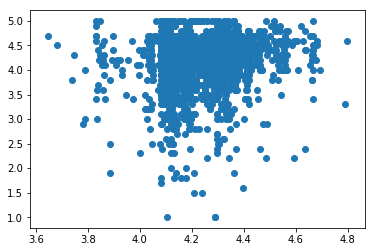

In [33]:
pre = model.predict(X_test)
plt.scatter(pre,Y_test)
plt.show()

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.25,random_state=1)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5793, 35)
(5793,)
(1931, 35)
(1931,)


In [27]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train,Y_train)
print(linreg.intercept_)
print(linreg.coef_)

6526845112.791957
[ 1.48618237e-03 -3.23345533e-04 -6.52684511e+09 -6.52684511e+09
 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09
 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09
 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09
 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09
 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09
 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09
 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09
 -6.52684511e+09 -6.52684511e+09 -6.52684511e+09]
